In [1]:
from utils import *

hete = Heterogeneity()
hete.check_torch_gpu()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: Python39 | Python version: 3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]
Torch version: 2.0.0+cu117
Torch build with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080



In [2]:
# Hyperparameters and configurations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device="{}"'.format(device))

lr         = 2e-4
batch_size = 50
num_epochs = 200

input_channels_X  = 5
output_channels_X = 5

input_channels_Y  = 2
output_channels_Y = 2

device="cuda"


In [3]:
# X_data, y_data = np.load('X_data.npy'), np.load('y_data.npy')
# print('X_data: {} | y_data: {}'.format(X_data.shape, y_data.shape))

# xn = np.moveaxis(np.moveaxis(X_data, -2, 1).reshape(2000*61,64,64,4), -1, 1)
# yn = np.moveaxis(np.moveaxis(y_data, -2, 1).reshape(2000*61,64,64,2), -1, 1)
# print('X_reshape: {} | y_reshape: {}'.format(xn.shape, yn.shape))

# train_dataset = NumpyDataset(xn, yn)
# dataloader    = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
X_data, y_data = np.load('X_temp.npy')[:50*10], np.load('y_temp.npy')[:50*10]
print(X_data.shape, y_data.shape)

train_dataset  = TensorDataset(torch.Tensor(X_data), torch.Tensor(y_data))
dataloader     = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

(500, 5, 64, 64) (500, 2, 64, 64)


In [5]:
# Initialize CycleGAN
cycle_gan = CycleGAN(input_channels_X, output_channels_Y, input_channels_Y, output_channels_X).to(device)

# Optimizers
optimizer_G   = optim.Adam(cycle_gan.parameters(), lr=lr)
optimizer_D_X = optim.Adam(cycle_gan.discriminator_X.parameters(), lr=lr)
optimizer_D_Y = optim.Adam(cycle_gan.discriminator_Y.parameters(), lr=lr)
optimizers = [optimizer_G, optimizer_D_X, optimizer_D_Y]

# Loss functions
adversarial_loss       = nn.MSELoss()
cycle_consistency_loss = nn.L1Loss()
losses = [cycle_consistency_loss, adversarial_loss]

fake_imgs, loss = cycle_gan.train(dataloader, num_epochs, optimizers, losses, save=True)

Epoch [10/200]: Generator Loss: 2.645, Discriminator Loss: 1.450


(2, 50, 2, 64, 64)


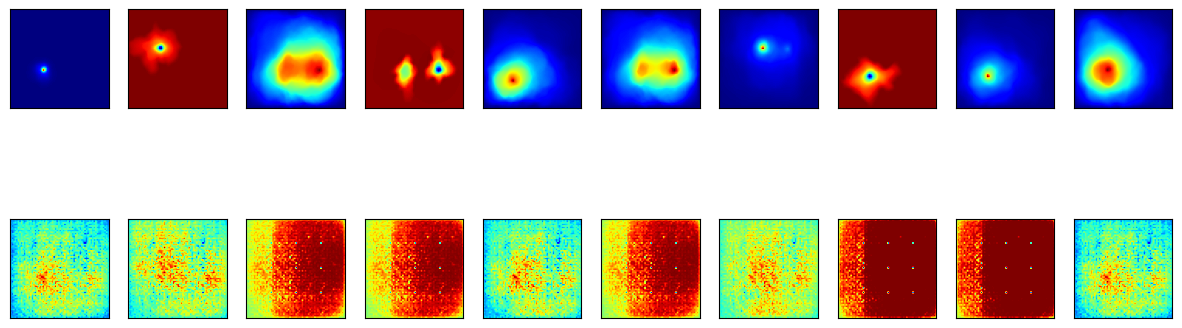

In [9]:
fi = fake_imgs.cpu().numpy().reshape(2,50,2,64,64)
print(fi.shape)

fig, axs = plt.subplots(2, 10, figsize=(15,5))
for i in range(2):
    for j in range(10):
        axs[i,j].imshow(fi[i, j*5, 0], 'jet')
        axs[i,j].set(xticks=[], yticks=[])

***
# END